### Sistema de Recomendação de Filmes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    precision_score,
    recall_score,
    f1_score
)


In [2]:

X_train = np.array([
[0, 1, 1],
[0, 0, 1],
[0, 0, 0],
[1, 1, 0]])

Y_train = ['Y', 'N', 'Y', 'Y']
X_test = np.array([[1,1,0]])

def get_label_indices(labels):
    """
    Group samples based on their labels and return indices
    @param labels: list of labels
    @return: dict, {class1: [indices], class2: [indices]}
    """
    # from collections import defaultdict
    label_indices = defaultdict(list)
    for index, label in enumerate(labels):
        label_indices[label].append(index)
    return label_indices

label_indices = get_label_indices(Y_train)
print(label_indices)

defaultdict(<class 'list'>, {'Y': [0, 2, 3], 'N': [1]})


In [3]:
def get_prior(label_indices):
    prior = {label: len(indices) for label, indices in label_indices.items()}
    total_count = sum(prior.values())
    for label in prior:
        prior[label] /= total_count
    return prior

prior = get_prior(label_indices)
prior

{'Y': 0.75, 'N': 0.25}

O código define uma função chamada `get_prior` que calcula a probabilidade a priori (prior) de cada classe em um conjunto de dados de classificação.

Explicação passo a passo:

- A função recebe como entrada `label_indices`, que é um dicionário onde as chaves são os rótulos das classes (por exemplo, 'Y' e 'N') e os valores são listas com os índices das amostras que pertencem a cada classe.
- Ela conta quantas amostras existem para cada classe.
- Soma o total de amostras.
- Para cada classe, divide o número de amostras daquela classe pelo total, obtendo assim a probabilidade a priori de cada classe (ou seja, a frequência relativa de cada classe no conjunto de treinamento).
- Retorna um dicionário com as probabilidades a priori de cada classe.

Exemplo:  
Se você tem 3 amostras da classe 'Y' e 1 da classe 'N', as probabilidades a priori serão {'Y': 0.75, 'N': 0.25}.

In [4]:
def get_likelihood(features, label_indices, smoothing=0):
    likelihood = {}
    for label, indices in label_indices.items():
        likelihood[label] = features[indices, :].sum(axis=0) + smoothing
        total_count =  len(indices) 
        likelihood[label] = likelihood[label] / (total_count + 2 * smoothing)
    return likelihood


likelihood = get_likelihood(X_train, label_indices, smoothing=1)
likelihood

{'Y': array([0.4, 0.6, 0.4]), 'N': array([0.33333333, 0.33333333, 0.66666667])}

Exemplo prático usando para ilustrar o que a função `get_likelihood` faz.

### Dados de treino



In [5]:
X_train = np.array([
    [0, 1, 1],
    [0, 0, 1],
    [0, 0, 0],
    [1, 1, 0]
])
Y_train = ['Y', 'N', 'Y', 'Y']



### Índices por classe



In [6]:
label_indices = get_label_indices(Y_train)
# Resultado: {'Y': [0, 2, 3], 'N': [1]}



### O que a função faz para cada classe

#### Para a classe 'Y' (`indices = [0, 2, 3]`):

Seleciona as linhas 0, 2 e 3 de `X_train`:


In [7]:
[0, 1, 1]   # índice 0
[0, 0, 0]   # índice 2
[1, 1, 0]   # índice 3

[1, 1, 0]



Soma por coluna:
- Primeira coluna: 0 + 0 + 1 = 1
- Segunda coluna: 1 + 0 + 1 = 2
- Terceira coluna: 1 + 0 + 0 = 1

Sem suavização (`smoothing=0`), divide cada soma pelo total de amostras da classe 'Y' (3):
- [1/3, 2/3, 1/3] ≈ [0.33, 0.67, 0.33]

#### Para a classe 'N' (`indices = [1]`):

Seleciona a linha 1 de `X_train`:


In [8]:
[0, 0, 1]

[0, 0, 1]



Soma por coluna:
- [0, 0, 1]

Divide pelo total de amostras da classe 'N' (1):
- [0/1, 0/1, 1/1] = [0, 0, 1]

### Resultado final esperado



In [9]:
{
    'Y': [0.33, 0.67, 0.33],
    'N': [0, 0, 1]
}

{'Y': [0.33, 0.67, 0.33], 'N': [0, 0, 1]}



Ou seja, a função retorna a probabilidade de cada feature ser 1, dado cada classe, baseada nos seus dados de treino.

In [10]:
def get_posterior(X, prior, likelihood):
    posteriors = []
    for x in X:
        posterior = prior.copy()
        for label, likelihood_label in likelihood.items():
            for index, bool_value in enumerate(x):
                posterior[label] *= likelihood_label[index] if bool_value else (1 - likelihood_label[index])
        sum_posterior = sum(posterior.values())
        for label in posterior:
            if posterior[label] == float('inf'):
                posterior[label] = 1.0
            else:
                posterior[label] = float(posterior[label] / sum_posterior)
        posteriors.append(posterior.copy())
    return posteriors


posterior = get_posterior(X_test, prior, likelihood)
posterior

[{'Y': 0.9210360075805433, 'N': 0.07896399241945673}]


### O que faz a função `get_posterior`

Ela calcula a **probabilidade posterior** de cada classe para cada amostra de entrada, usando o teorema de Bayes.  
Ou seja, dado um vetor de características (features), ela retorna a probabilidade de pertencer a cada classe ('Y' ou 'N').

### Passos da função:

1. Para cada amostra `x` em `X`:
    - Copia o dicionário de probabilidades a priori (`prior`).
2. Para cada classe (`label`):
    - Para cada feature:
        - Multiplica a probabilidade pelo valor da verossimilhança (likelihood) se a feature for 1, ou por (1 - likelihood) se for 0.
3. Após multiplicar todas as probabilidades, normaliza os valores para que a soma das probabilidades das classes seja 1.
4. Adiciona o resultado à lista de posteriors.

---

### Exemplo didático
### Dados de treino



In [11]:
X_train = np.array([
    [0, 1, 1],
    [0, 0, 1],
    [0, 0, 0],
    [1, 1, 0]
])
Y_train = ['Y', 'N', 'Y', 'Y']



### Priors (probabilidades a priori)



In [12]:
prior = {'Y': 0.75, 'N': 0.25}



### Likelihoods (probabilidades condicionais)

Suponha que você já calculou:



In [13]:
likelihood = {
    'Y': np.array([0.4, 0.6, 0.4]),
    'N': np.array([0.33333333, 0.33333333, 0.66666667])
}



### Amostra de teste



In [14]:
X_test = np.array([[1, 1, 0]])



### Cálculo passo a passo para `X_test[0] = [1, 1, 0]`

#### Para classe 'Y':

- prior: 0.75
- likelihoods: [0.4, 0.6, 0.4]
- features: [1, 1, 0]

Multiplica:
- 0.75 × 0.4 (feature 1 é 1)  
- × 0.6 (feature 2 é 1)  
- × (1 - 0.4) = 0.6 (feature 3 é 0)  

Resultado:  
0.75 × 0.4 × 0.6 × 0.6 = **0.108**

#### Para classe 'N':

- prior: 0.25
- likelihoods: [0.333..., 0.333..., 0.666...]
- features: [1, 1, 0]

Multiplica:
- 0.25 × 0.333... (feature 1 é 1)  
- × 0.333... (feature 2 é 1)  
- × (1 - 0.666...) = 0.333... (feature 3 é 0)  

Resultado:  
0.25 × 0.333... × 0.333... × 0.333... ≈ **0.00926**

#### Normalização

Soma total: 0.108 + 0.00926 ≈ 0.11726

Probabilidades finais:
- 'Y': 0.108 / 0.11726 ≈ **0.921**
- 'N': 0.00926 / 0.11726 ≈ **0.079**

---

## Resumindo

A função retorna:



In [15]:
[{'Y': 0.921, 'N': 0.079}]

[{'Y': 0.921, 'N': 0.079}]



Ou seja, para a amostra `[1, 1, 0]`, a probabilidade de ser 'Y' é 92,1% e de ser 'N' é 7,9%.

Se quiser ver isso na prática, basta rodar:



In [16]:
posteriors = get_posterior(X_test, prior, likelihood)
print(posteriors)

[{'Y': 0.9210360097624036, 'N': 0.07896399023759633}]




Assim, você pode classificar novas amostras com base nas probabilidades calculadas!

In [17]:


clf = BernoulliNB(alpha=1.0, fit_prior=True)
clf.fit(X_train, Y_train)

pred_prob = clf.predict_proba(X_test)
print(pred_prob)

pred = clf.predict(X_test)
print(pred)

[[0.07896399 0.92103601]]
['Y']


In [ ]:
data_path = r'movie_recommender\ratings.csv'
df = pd.read_csv(data_path)
n_users = 6040
n_movies = 3706


In [19]:
def load_rating_data(data_path, n_users):
    from collections import defaultdict
    movie_id_mapping = {}
    movie_n_rating = defaultdict(int)
    user_movie_ratings = []

    with open(data_path, 'r') as file:
        for line in file.readlines()[1:]:
            user_id, movie_id, rating, _ = line.strip().split(",")
            user_id = int(user_id) - 1
            if movie_id not in movie_id_mapping:
                movie_id_mapping[movie_id] = len(movie_id_mapping)
            movie_idx = movie_id_mapping[movie_id]
            rating = float(rating)
            user_movie_ratings.append((user_id, movie_idx, rating))
            if rating > 0:
                movie_n_rating[movie_id] += 1

    n_movies = len(movie_id_mapping)
    data = np.zeros([n_users, n_movies], dtype=np.float32)
    for user_id, movie_idx, rating in user_movie_ratings:
        data[user_id, movie_idx] = rating

    return data, movie_n_rating, movie_id_mapping
data, movie_n_rating, movie_id_mapping = load_rating_data(data_path, n_users)

In [20]:
def display_distribution(data):
    values, counts = np.unique(data, return_counts=True)
    for value, count in zip(values, counts):
        print(f'Number of rating {value}: {count}')
display_distribution(data)

Number of rating 0.0: 58632124
Number of rating 0.5: 1370
Number of rating 1.0: 2811
Number of rating 1.5: 1791
Number of rating 2.0: 7551
Number of rating 2.5: 5550
Number of rating 3.0: 20047
Number of rating 3.5: 13136
Number of rating 4.0: 26818
Number of rating 4.5: 8551
Number of rating 5.0: 13211


In [21]:
# Supondo que movie_n_rating já foi criado pela função load_rating_data
most_rated_movie = max(movie_n_rating, key=movie_n_rating.get)
print(f'O filme com mais avaliações é o ID {most_rated_movie} com {movie_n_rating[most_rated_movie]} avaliações.')

O filme com mais avaliações é o ID 356 com 329 avaliações.


In [37]:
X_raw = np.delete(data, movie_id_mapping[most_rated_movie], axis=1)
Y_raw = data[:, movie_id_mapping[most_rated_movie]]

X = X_raw[Y_raw > 0]
Y = Y_raw[Y_raw > 0]
print('Shape of X:', X.shape)
print('Shape of Y:', Y.shape)
display_distribution(Y)

Shape of X: (329, 9723)
Shape of Y: (329,)
Number of rating 0.5: 1
Number of rating 1.0: 1
Number of rating 2.0: 9
Number of rating 2.5: 3
Number of rating 3.0: 39
Number of rating 3.5: 27
Number of rating 4.0: 94
Number of rating 4.5: 39
Number of rating 5.0: 116


In [24]:
recommend = 3
Y[Y <= recommend] = 0
Y[Y > recommend] = 1
n_pos = (Y == 1).sum()
n_neg = (Y == 0).sum()
print(f'{n_pos} positivos e {n_neg} negativos')


276 positivos e 53 negativos


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)
print(len(Y_train), len(Y_test))

263 66


In [26]:

clf = MultinomialNB(alpha=1.0, fit_prior=True)
clf.fit(X_train, Y_train)


,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [27]:
prediction_prob = clf.predict_proba(X_test)
print(prediction_prob[0:10])

[[1.00000000e+000 5.82868571e-012]
 [2.19253080e-057 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [1.27490395e-008 9.99999987e-001]
 [3.64187923e-124 1.00000000e+000]
 [1.89334551e-277 1.00000000e+000]
 [3.65697000e-042 1.00000000e+000]
 [1.55224375e-016 1.00000000e+000]
 [1.79410667e-222 1.00000000e+000]
 [6.05684624e-009 9.99999994e-001]]


In [28]:
prediction = clf.predict(X_test)
print(prediction[:10])

[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [29]:
# Avaliar o desempenho do modelo
accuracy = clf.score(X_test, Y_test)
print(f'Accuracy: {accuracy*100:.1f}%')

Accuracy: 78.8%


In [30]:
print(confusion_matrix(Y_test, prediction, labels=[0, 1]))
print(f'precision_score: {precision_score(Y_test, prediction)*100:.1f}%')
print(f'recall_score: {recall_score(Y_test, prediction, pos_label=1)*100:.1f}%')
print(f'f1_score: {f1_score(Y_test, prediction, pos_label=1)*100:.1f}%')



[[ 2  9]
 [ 5 50]]
precision_score: 84.7%
recall_score: 90.9%
f1_score: 87.7%


In [31]:
pos_prob = prediction_prob[:, 1]
thresholds = np.arange(0.0, 1.1, 0.05)
true_pos = [0] * len(thresholds)
false_pos = [0] * len(thresholds)

for pred, y in zip(pos_prob, Y_test):
    for i, threshold in enumerate(thresholds):
        if pred >= threshold:
            # if truth and prediction are both 1
            if y == 1:
                true_pos[i] += 1
            # if truth is 0 while prediction is 1
            else:
                false_pos[i] += 1
        else:
            break

n_pos_test = (Y_test == 1).sum()
n_neg_test = (Y_test == 0).sum()
true_pos_rate = [tp / n_pos_test for tp in true_pos]
false_pos_rate = [fp / n_neg_test for fp in false_pos]

C:\Users\aoliveira_esss\AppData\Local\Temp\ipykernel_18904\1934380004.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


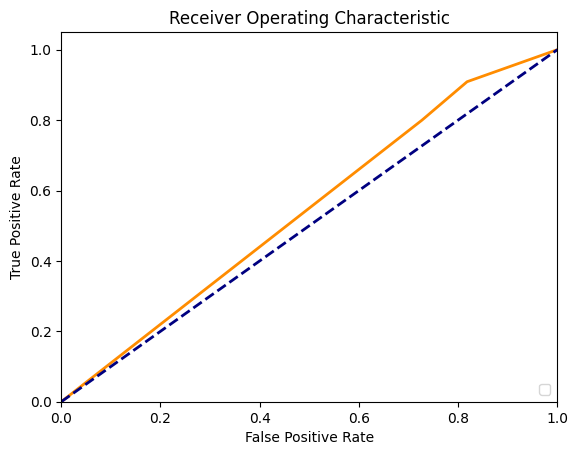

In [32]:
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color='darkorange', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [33]:

roc_auc_score(Y_test, pos_prob)

0.543801652892562

In [34]:

k = 5
k_fold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

smoothing_factor_option = [1, 2, 3, 4, 5, 6]
fit_prior_option = [True, False]
auc_record = {}

for train_indices, test_indices in k_fold.split(X, Y):
    X_train, X_test = X[train_indices], X[test_indices]
    Y_train, Y_test = Y[train_indices], Y[test_indices]
    for alpha in smoothing_factor_option:
        if alpha not in auc_record:
            auc_record[alpha] = {}
        for fit_prior in fit_prior_option:
            clf = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
            clf.fit(X_train, Y_train)
            prediction_prob = clf.predict_proba(X_test)
            pos_prob = prediction_prob[:, 1]
            auc = roc_auc_score(Y_test, pos_prob)
            auc_record[alpha][fit_prior] = auc + auc_record[alpha].get(fit_prior, 0.0)

for smoothing, smoothing_record in auc_record.items():
    for fit_prior, auc in smoothing_record.items():
        print(f' {smoothing} {fit_prior} {auc/k:.5f}')


 1 True 0.58146
 1 False 0.59746
 2 True 0.57716
 2 False 0.57716
 3 True 0.56290
 3 False 0.56165
 4 True 0.56287
 4 False 0.56287
 5 True 0.55586
 5 False 0.55586
 6 True 0.55295
 6 False 0.55163


In [ ]:
# from sklearn.model_selection import cross_val_score

clf = MultinomialNB(alpha=2.0, fit_prior=False)
auc_scores = cross_val_score(clf, X, Y, cv=5, scoring='roc_auc')
print('AUC médio na validação cruzada:', auc_scores.mean())